**Frequency dressed with -40 dB:** 7.579121159 GHz

In [2]:
%matplotlib widget
import pyvisa
import matplotlib.pyplot as plt
import numpy as np
import time
from scipy.optimize import curve_fit


import sys 
sys.path.insert(0, r'C:\Users\oper\SynologyDrive\Lab2023\KIDs\QTLab2324\PAandQubit\Actual_Work')
sys.path.insert(1, r'C:\Users\oper\SynologyDrive\Lab2023\KIDs\QTLab2324\PAandQubit\Instruments\network\RS_Signal_Generator')
sys.path.insert(2, r'C:\Users\oper\SynologyDrive\Lab2023\KIDs\QTLab2324\PAandQubit\Instruments\network\VNA')

import FunFit as FF
import Tuls as Ts
import RS_SMA100B
import NA_N9916A

ip_sg           = '192.168.40.15' 
ip_vna          = '192.168.40.10' 
vna             = NA_N9916A.N9916A(ip = ip_vna)
sGen            = RS_SMA100B.SMA100B(ip = ip_sg)

N9916A:	Connection successful!
SMA100B:	Connection successful!


In [55]:
# f0 = vna.get_freqs()
# f0 = np.mean(np.array([int(i) for i in f0.split(',')]))
# f0 = 7.579121159e9
f0 = 7.5788290e9

mode        = 'NA'              
s_par       = 'S21'       
f_span      = 1
f_center    = f0
bw          = 100e3            # IF BANDWIDTH
n_avgs      = 1
n_pts       = 600  
                            
###############################

vna.set_mode(mode)
vna.set_NA_par(s_par)
vna.run_hold('RUN')
vna.set_num_pts(n_pts)
vna.set_freq_bandwidth(bw)
vna.set_freq_span(f_span)
vna.set_freq_center(f_center)
vna.num_avgs(n_avgs)
vna.set_scaling(auto = True)

sGen.RF_lvl_ampl(-25)

In [60]:
f_sg_min    = 5.76e9
f_sg_max    = 5.775e9
f_step      = 0.5e6

lvl_vna_min  = -45
lvl_vna_max  = -35
lvl_step    = 2

freqs_sg    = np.arange(f_sg_min, f_sg_max, f_step)
lvl_vna      = np.arange(lvl_vna_min, lvl_vna_max, lvl_step)

print('len freqs:\t', len(freqs_sg))
print('len lvl:\t', len(lvl_vna))

tempoh = int(2*(len(freqs_sg)*len(lvl_vna))/60)

print('tempo stimato operazione: ', tempoh, ' minuti.')

len freqs:	 30
len lvl:	 5
tempo stimato operazione:  5  minuti.


## Ciclo per il punchout:
Fissata la potenza e la frequenza di readout dal VNA, viene effettuato uno scanning in frequenza e in potenza attraverso il segnale di drive mandato con il Signal Generator. Lo scopo è quello di fare una rappresentazione di punchout in cui si possano osservare i primi quattro livelli energetici del qubit.

**INPUT:** 
	
	- Fissati:
		- Frequenza          (VNA)
		- Potenza            (VNA)
		- Span               (VNA)
		- Bandwidth          (VNA)
		- Number of averages (VNA)
		- Number of points   (VNA)
	- Variabili:
		- Potenza            (SG)
		- Frequenza          (SG)

**OUTPUT:**

	- P_j
		- (f_i, ..., f_k)
			- Media su tutti i punti del modulo I-Q
	.
	.
	.
	- P_s
		- (f_i, ..., f_k)
			- Media su tutti i punti del modulo I-Q
	--------------------------------------------------
	x = Set di frequenze      (SG)
	y = Set di potenze        (SG)
	z = Set di medie ottenute (SG)

100%(5,)
(30,)
(5, 30)


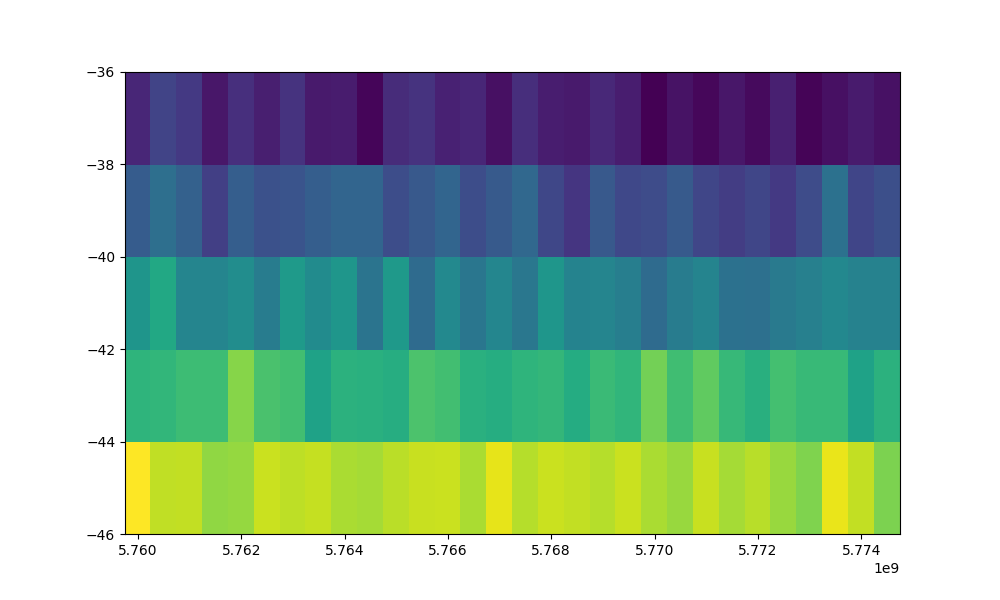

In [61]:
import numpy as np
import time
import matplotlib.pyplot as plt

MSR = []
counter = 1
for p in lvl_vna:
	vna.power = p
	sGen.RF_state(1)
	amps = []
	for f in freqs_sg:
		print(f'\r{int(counter*100/len(freqs_sg)/len(lvl_vna))}%', end='', flush = True)
		counter += 1
		sGen.RF_freq(f)
		time.sleep(1)
		data = vna.get_data()
		amp = np.mean(5*np.log10(data['Q']**2 + data['I']**2))
		amps.append(amp)
	amps = np.array(amps)
	MSR.append(amps)
	sGen.RF_state(0)
MSR = np.array(MSR)


print(lvl_vna.shape)
print(freqs_sg.shape)
print(MSR.shape)


fig = plt.figure(figsize = (10,6))
plt.pcolor(freqs_sg, lvl_vna, MSR)

plt.show()

In [64]:
import plotly.express as px

taitol = 'Spettroscopia in potenza Stark Shift 2 (20 dBm), Normalizzata per riga'

att = 20 + 3                # Attenuazione out of power combiner (dBm) + attenuazione power_comb (dBm)

MSR = Ts.load_hdf5_to_dict('Spec_StarkShift_20dBm_25dBmGen210624.h5')['measurments']['Measuerments']
freqs_sg = Ts.load_hdf5_to_dict('Spec_StarkShift_20dBm_25dBmGen210624.h5')['measurments']['f_sig_gen']
lvl_vna = Ts.load_hdf5_to_dict('Spec_StarkShift_20dBm_25dBmGen210624.h5')['measurments']['dBm_vna']


fig = px.imshow(MSR/np.min(MSR, axis = 1, keepdims = True), aspect="auto", labels=dict(x = 'Frequency (GHz)', y = 'Power (dB)', z = 'MSR'), x = freqs_sg/1e9, y = lvl_vna - att, origin = 'lower', title = taitol)

fig.update_layout(
    width = 1000,
    height = 600
    )

fig.update_traces(hoverongaps=False, hovertemplate='Frequency: %{x}<br>Amplitude: %{y}<br>MSR: %{z}')

In [59]:
description = 'Ampl_vna_in: +16dBm\n\n Atten_vna_before_power_combiner(dunque NON attenua sig_gen): -20 dBm\n\n Atten power combiner: -3 dbm \n\n  f_VNA: 7.5788290e9 Hz\n\n power_sig_gen: -25dBm '

data = {'Description': description, 'measurments': {'f_sig_gen': freqs_sg, 'dBm_vna': lvl_vna , 'Measuerments': MSR}}

Ts.save_dict_to_hdf5(data, 'Spec_StarkShift_20dBm_25dBmGen210624_corto.h5')